<a href="https://colab.research.google.com/github/edwardauron/DS-Unit-2-Sprint-4-Model-Validation/blob/master/module-2-validate-classification-problems/Logisitic_Cross_Validation_Assignmentrip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U -q kaggle
!pip install seaborn==0.9.0

In [2]:
!pip install yellowbrick

In [3]:
# for colab 
# !mkdir -p ~/.kaggle

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# colab only
# from google.colab import files 

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_regression, SelectKBest, RFE
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, brier_score_loss, 
                             precision_score, recall_score, f1_score)

from sklearn.model_selection import (train_test_split, cross_val_predict, 
                                     GridSearchCV, StratifiedKFold)

from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder, RobustScaler,
                                   PolynomialFeatures)
from sklearn.svm import LinearSVC
from yellowbrick.classifier import ROCAUC
from zipfile import ZipFile

In [5]:
# colab only
# files.upload()

In [6]:
# colab only
# !cp kaggle.json ~/.kaggle/

In [7]:
# colab only
# !kaggle datasets download -d ntnu-testimon/paysim1

In [8]:
#!ls

In [9]:
#!unzip paysim1.zip

In [10]:
#!ls

In [48]:
df = pd.read_csv('X:\Data\paysim1\SFraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Let's label encode our names, and hot encode our types of payment for better processing. We choose not to label encode any numerical values, because they are attached to unique instances of customer interaction. If we had one input for multiple, like a lot, of outputs, label encoding would be a fine choice for numerical consistency.

In [5]:
df.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [7]:
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0,0,0,0,1,0


In [8]:
df.step.max()

743

# Something weird
It looks like step goes all the way up to 743, i found some papers handling sequential data, but for now i think im actually going to drop step, because i honestly dont know how to handle it. 

In [49]:
df = df.drop('step', axis=1)

In [50]:
df_y_positive = df[df.isFraud == 1]
df_y_positive.shape

(8213, 10)

In [51]:
df = df[df.isFraud == 0]
df = df[1:8214]
df.shape

(8213, 10)

In [55]:
df = df.append(df_y_positive)

In [57]:
df.shape

(16426, 10)

In [58]:
df.isna().sum()

type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [60]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.0,0,0
4,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.0,0,0
5,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.0,0,0
6,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.0,0,0
7,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.0,0,0


# Let's label/encode
Customer -> Merchant unique transfers as labels, hot encode the type

In [61]:
le = LabelEncoder()
labels = ['nameOrig', 'nameDest']
for label in labels:
  df[label] = le.fit_transform(df[label].values)

In [62]:
df = pd.get_dummies(df, prefix=['type'])

In [63]:
y = df['isFraud']
X = df.drop(['isFraud'], axis=1)

In [83]:
X.head()

,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
1,1864.28,5764,21249.00,19384.72,11311,0.0,0.0,0,0,0,0,1,0
4,11668.14,9082,41554.00,29885.86,9393,0.0,0.0,0,0,0,0,1,0
5,7817.71,15547,53860.00,46042.29,12399,0.0,0.0,0,0,0,0,1,0
6,7107.77,4722,183195.00,176087.23,12017,0.0,0.0,0,0,0,0,1,0
7,7861.64,7897,176087.23,168225.59,12544,0.0,0.0,0,0,0,0,1,0


# Creating relationships with entropy and seeing which of them stick.

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)

In [65]:
X_train.shape

(11498, 13)

In [66]:
poly_transform = PolynomialFeatures(degree=2)
X_polynomial = poly_transform.fit_transform(X_train)

print(X_train.shape, X_polynomial.shape)

(11498, 13) (11498, 105)


In [86]:
pd.DataFrame(poly_transform.fit_transform(X_train))

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,1.0,8791.02,16364.0,41330.00,32538.98,9703.0,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,684174.46,14423.0,684174.46,0.00,8289.0,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,147459.35,7982.0,0.00,0.00,469.0,11590178.72,11919932.15,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,476.55,13369.0,0.00,0.00,12473.0,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,46073.56,4145.0,46073.56,0.00,2364.0,1962.98,48036.54,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,166335.32,5421.0,0.00,0.00,5783.0,1739306.48,1517262.16,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,4510.15,9497.0,15966.00,11455.85,11091.0,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,1.0,302665.03,5008.0,40130.00,0.00,2610.0,0.00,217862.21,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,1.0,395709.23,9505.0,0.00,0.00,8858.0,446219.81,1097218.45,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,1.0,1762680.47,8473.0,1762680.47,0.00,146.0,3039981.66,4802662.12,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
scaler = RobustScaler()
X_sample_scaled = scaler.fit_transform(X_polynomial)

In [68]:
# creating the feature selector

lr = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, 
                   random_state=None, solver='sag', max_iter=10000, multi_class='warn', verbose=1, warm_start=False, n_jobs=2)

rfe = RFE(lr, n_features_to_select=None, step=1, verbose=1)

In [69]:
X_poly_sub = rfe.fit_transform(X_sample_scaled, y_train)


Fitting estimator with 105 features.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 43 seconds
Fitting estimator with 104 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   43.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4133 epochs took 43 seconds
Fitting estimator with 103 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   42.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4131 epochs took 42 seconds
Fitting estimator with 102 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   42.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 42 seconds
Fitting estimator with 101 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   41.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 42 seconds
Fitting estimator with 100 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   41.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4131 epochs took 49 seconds
Fitting estimator with 99 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   48.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4131 epochs took 41 seconds
Fitting estimator with 98 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   41.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4133 epochs took 43 seconds
Fitting estimator with 97 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   43.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4131 epochs took 42 seconds
Fitting estimator with 96 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   41.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4133 epochs took 41 seconds
Fitting estimator with 95 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   41.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4131 epochs took 49 seconds
Fitting estimator with 94 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   48.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 41 seconds
Fitting estimator with 93 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   40.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4134 epochs took 41 seconds
Fitting estimator with 92 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   40.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 40 seconds
Fitting estimator with 91 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   39.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 40 seconds
Fitting estimator with 90 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   39.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4133 epochs took 39 seconds
Fitting estimator with 89 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   39.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4131 epochs took 39 seconds
Fitting estimator with 88 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   38.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4131 epochs took 39 seconds
Fitting estimator with 87 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   38.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4133 epochs took 39 seconds
Fitting estimator with 86 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   38.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 38 seconds
Fitting estimator with 85 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   38.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 40 seconds
Fitting estimator with 84 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   39.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4130 epochs took 38 seconds
Fitting estimator with 83 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   38.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4133 epochs took 38 seconds
Fitting estimator with 82 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   38.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4131 epochs took 37 seconds
Fitting estimator with 81 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   37.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4133 epochs took 36 seconds
Fitting estimator with 80 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   36.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 37 seconds
Fitting estimator with 79 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   36.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4133 epochs took 36 seconds
Fitting estimator with 78 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   35.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4131 epochs took 36 seconds
Fitting estimator with 77 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   35.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 35 seconds
Fitting estimator with 76 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   35.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4131 epochs took 36 seconds
Fitting estimator with 75 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   35.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4133 epochs took 35 seconds
Fitting estimator with 74 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   34.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 34 seconds
Fitting estimator with 73 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   34.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4133 epochs took 34 seconds
Fitting estimator with 72 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   33.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 34 seconds
Fitting estimator with 71 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   33.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 33 seconds
Fitting estimator with 70 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   33.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4133 epochs took 34 seconds
Fitting estimator with 69 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   33.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4131 epochs took 32 seconds
Fitting estimator with 68 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   32.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4133 epochs took 33 seconds
Fitting estimator with 67 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   32.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4131 epochs took 32 seconds
Fitting estimator with 66 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   32.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 35 seconds
Fitting estimator with 65 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   35.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 36 seconds
Fitting estimator with 64 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   35.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 33 seconds
Fitting estimator with 63 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   32.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4133 epochs took 31 seconds
Fitting estimator with 62 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   31.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 30 seconds
Fitting estimator with 61 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   30.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4133 epochs took 31 seconds
Fitting estimator with 60 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   30.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 30 seconds
Fitting estimator with 59 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   29.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4133 epochs took 29 seconds
Fitting estimator with 58 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   29.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 35 seconds
Fitting estimator with 57 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   34.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4130 epochs took 28 seconds
Fitting estimator with 56 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   28.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 28 seconds
Fitting estimator with 55 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   28.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 28 seconds
Fitting estimator with 54 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   27.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4131 epochs took 27 seconds
Fitting estimator with 53 features.


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   27.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4132 epochs took 28 seconds


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   27.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 4131 epochs took 27 seconds


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   26.7s finished


In [82]:
rfe.ranking_

array([54,  2, 35,  6,  1, 16, 23, 12, 32, 29, 24, 27, 17, 21,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 31,  3,  1, 20, 13,  5,  1,
        1, 10,  1,  1,  7,  1,  1,  4,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       26,  1,  1,  1,  1,  1,  1,  1,  1, 14, 19,  9,  1,  1, 11,  1, 15,
        8,  1,  1, 38,  1,  1,  1, 37,  1,  1, 46,  1,  1,  1, 45,  1, 34,
       43, 47, 52, 49, 33, 30, 44, 36, 51, 50, 25, 42, 41, 40, 28, 39, 53,
       18, 48, 22])

# Now that cleaning, scaling and feature engineering is complete, let's run our model.

In [73]:
param_grid = {
    'C': [0.001,0.01,0.1,1,10,100,1000]
}

gs = GridSearchCV(lr, param_grid=param_grid, cv=3,
                 scoring='accuracy', verbose=1)

gs.fit(X_poly_sub, y_train)


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   17.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   17.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   17.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   17.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   18.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   17.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend w

convergence after 4131 epochs took 28 seconds


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   28.7s finished


NameError: name 'validation_score' is not defined

In [78]:
validation_score = gs.best_score_
print('\nCross-Validation Score:', validation_score, '\nBest estimator:', gs.best_estimator_)


Cross-Validation Score: 0.9421638545834058 
Best estimator: LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=2, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=1, warm_start=False)


# Into the fold


In [77]:
X_test_polynomial = poly_transform.transform(X_test)
X_test_scaled = scaler.transform(X_test_polynomial)
X_test_subset = rfe.transform(X_test_scaled)

# Use the grid search's score method with X_test_subset
test_score = gs.score(X_test_subset, y_test)
print('Test Score:', test_score)

Test Score: 0.9409496753246753


In [94]:
predictions = gs.predict(X_test_subset)
logi_report = classification_report(y_test, predictions)
print(logi_report)

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      2464
           1       0.90      0.99      0.94      2464

   micro avg       0.94      0.94      0.94      4928
   macro avg       0.95      0.94      0.94      4928
weighted avg       0.95      0.94      0.94      4928



# Looking at exact values


In [95]:
x = confusion_matrix(y_test, predictions)

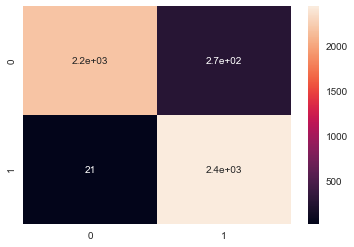

In [96]:
sns.heatmap(x, annot=True)

# ROC_AUC

http://www.scikit-yb.org/en/latest/api/classifier/rocauc.html

'ROC curve displays the true positive rate on the Y axis and the false positive rate on the X axis on both a global average and per-class basis. The ideal point is therefore the top-left corner of the plot: false positives are zero and true positives are one.''

In [97]:
roc_auc =  ROCAUC(gs)
roc_auc.fit(X_poly_sub, y_train)
show_me = roc_auc.poof()

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   18.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   18.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   17.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   18.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   18.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   17.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend w

convergence after 4132 epochs took 28 seconds


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   27.4s finished


0.9409496753246753

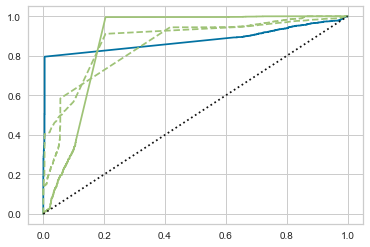

In [98]:
roc_auc.score(X_test_subset, y_test)